# Quantum Information and Holography: integrable vs scrambled systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions as ps1f
import numpy.linalg as la

Define integrable and scrambled hamiltonians.

In [2]:
def Hi(n_qubits):
    Hi = -ps1f.ZZ(n_qubits) - ps1f.X(n_qubits)
    return Hi

def Hs(n_qubits):
    Hs = -ps1f.ZZ(n_qubits) + 1.05*ps1f.X(n_qubits) - 0.5*ps1f.Z(n_qubits)
    return Hs

#Hamiltonians for part 4
def H3(n_qubits):
    H3 = -ps1f.ZZ(n_qubits) + 0.55*ps1f.X(n_qubits)
    return H3

def H4(n_qubits):
    H4 = -ps1f.ZZ(n_qubits) - ps1f.X(n_qubits) - 0.5*ps1f.Z(n_qubits)
    return H4

## Measure 1: Out-Of-Time-Ordered Correlator (OTOC)

Quantum OTOCs can be constructed as analogs of the classical Lyapunov exponents that measure the instability of classical trajectories arising from perturbations in the initial conditions [Zhang et al]. OTOC is a measure of scrambling in the system and thus becoming a measure of quantum chaos. The OTOC diagnoses the spread of quantum information by measuring how quickly two commuting operators fail to commute.

In [3]:
def get_U(t, e, v):
    """
    Inputs: t, time to evolve
            e, a 1d array containing eigenvalues of H
            v, a matrix whose columns are the corresponding eigenvectors
    Output: exp(-i H t)
    """
    #if H is diag({eigenvalues}), its exponential will be a diagonal matrix
    #such that its diagonal entries are exp(eigenvalue)
    diagonal_matrix = np.diag([np.exp(-1j*eigenvalue*t) for eigenvalue in e])
    #change basis using singularity matrix v
    U = la.multi_dot([v,diagonal_matrix, la.inv(v)])
    return U

In [4]:
def OTOC(t, e, v, site2, site1=0, op = ps1f.Sz):
    """
    Input: evolution time t, eigenpairs (e,v) of H, 
        two lattice sites, and a single-qubit operator
    Output: the OTOC
     < op(t)_site1 @ op(0)_site2 @ op(t)_site1 @ op(0)_site2 >
    """
    n = int(np.log2(len(e)))

    U = get_U(t,e,v)
    
    site1_oplist = [ps1f.Id]*site1 + [op] + [ps1f.Id]*(n-site1-1)
    site1_op = ps1f.kron_list(site1_oplist)
    site2_oplist = [ps1f.Id]*site2 + [op] + [ps1f.Id]*(n-site2-1)
    site2_op = ps1f.kron_list(site2_oplist)
    
    U_dagger = np.conjugate(U.T)
    dim = 2**n
    OTOC = np.trace(la.multi_dot([U_dagger, site1_op, U, site2_op, U_dagger, site1_op, U, site2_op]))/dim
    
    return OTOC

In [5]:
def plot_OTOC_vs_t(H, t0, sys_type, t_steps = 101):
    #number of spins
    n = int(np.log2(H.shape[0]))
    
    #solve Hamiltonian
    e,v = la.eigh(H)
    
    ts = np.linspace(0,t0,t_steps)
    OTOCs = np.zeros( (n, len(ts)), dtype = complex )
    
    for i in range(n):
        for t_idx, t in enumerate(ts):
            OTOCs[i, t_idx] = OTOC(t,e,v,i)
            
    #take real part, imaginary should be small
    OTOCs = np.real_if_close(OTOCs)
    
    title = 'OTOC measure for spins in chain - ' + sys_type 
    plt.title(title)
    for i in range(n):
        plt.plot(ts, OTOCs[i], label='spin'+str(i))
    plt.xlabel(r'$t$')
    plt.ylabel('OTOC')
    plt.legend(loc = 'upper right')
    plt.plot()

Define system and metric parameters

In [6]:
n_qubits = 8
t0 = 20
t_steps = 200 #t in range 0 -> 20 with step size 0.1 gives 200 timesteps

Plot OTOC comparison:

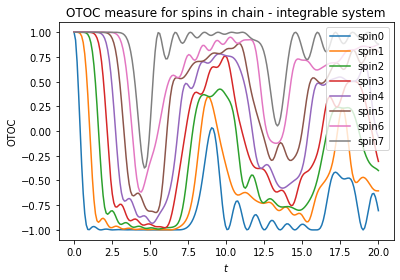

In [7]:
plot_OTOC_vs_t(Hi(n_qubits), t0, sys_type = 'integrable system', t_steps = t_steps);

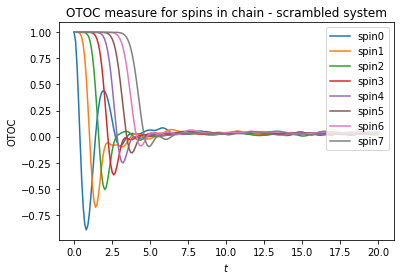

In [8]:
plot_OTOC_vs_t(Hs(n_qubits), t0, sys_type = 'scrambled system', t_steps = t_steps);

**Results**: for the scrambled system the OTOC decays with time. This is because the system becomes entangled, which is not the case for the integrable system.

## Measure 2: Operator Weight

Measure of operator spreading. We will opt for the first method for this problem.

In [9]:
def Z0_weight_vs_t_v1(t, e, v):
    #formulas derived separatedly
    
    n = int(np.log2(len(e)))
    dim = 2**n
    
    U = get_U(t,e,v)
    U_dagger = np.conjugate(U.T)
    Z0 = ps1f.kron_list( [ps1f.Sz] + [ps1f.Id]*(n-1) )
    Z0t = U_dagger.dot(Z0.dot(U))
    
    one_site_Pauli_ops = [ps1f.Id, ps1f.Sz, ps1f.Sx, ps1f.Sy]
    operator_inds = [ [ (elt//(4**j)) % 4 for j in range(n) ][::-1] for elt in range(4**n) ]
    Pauli_ops = np.array([ [one_site_Pauli_ops[ind] for ind in inds] for inds in operator_inds ])
    
    #list of weights :number of sites where the local Pauli is X, Y , or Z, rather than Id
    weights = np.sum(np.trace(Pauli_ops,axis1=2,axis2=3) == 0,axis=1)
    
    #list of coefficients: given by Tr[OP]/dim as per derivation
    operators_dot_Z0t = np.array([ps1f.kron_list(pauli_op).dot(Z0t) for pauli_op in Pauli_ops])
    coeffs = np.trace(operators_dot_Z0t,axis1=1,axis2=2) / dim
    #print(np.sum(abs(coeffs)*abs(coeffs))) #gives us ~1 as derived
    
    #weight for each basis state
    weight = np.sum(np.abs(coeffs)**2 * weights)
    
    return weight

In [10]:
def plot_Z0_weight_vs_t(H, t0, sys_type, t_steps = 101):
    
    e,v = np.linalg.eigh(H)
    
    ts = np.linspace(0,t0,t_steps)
    Z0_weights = np.zeros(ts.shape)
    for t_idx, t in enumerate(ts):
        Z0_weights[t_idx] = Z0_weight_vs_t_v1(t, e, v)
    
    title = 'Operator weight evolution - ' + sys_type 
    plt.title(title)
    plt.plot(ts, Z0_weights)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$Z_0(t)$ weight')
    plt.plot()

Define system and metric parameters:

In [11]:
n_qubits = 6
t0 = 30
t_steps = 600

Plot weight evolution comparison:

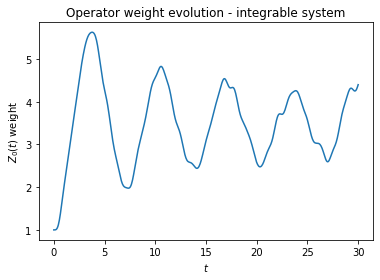

In [12]:
plot_Z0_weight_vs_t(Hi(n_qubits), t0, 'integrable system', t_steps);

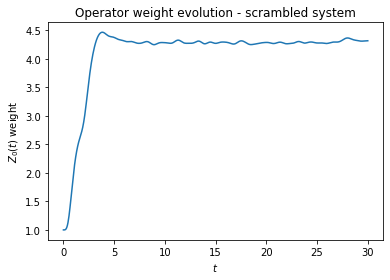

In [13]:
plot_Z0_weight_vs_t(Hs(n_qubits), t0, 'scrambled system', t_steps);

For the scrambling case, we see the operator spreading.

## Measure 3: Entanglement in the Choi state

Our goal will be to find, in this state, the mutual information between site 7 on the left and site 7 on the
right. 

In [14]:
def get_two_site_dm(t, e, v, left_site, right_site):
    n = int(np.log2(len(e)))
    
    U = get_U(t,e,v)
    U_dagger = np.conjugate(U.T)
    dim = (2**n)
    
    def full_space_op(one_site_op, site):
        return ps1f.kron_list([ps1f.Id]*site + [one_site_op] + [ps1f.Id]*(n-1-site))
    
    Z0 = full_space_op(ps1f.Sz, 0)
    
    # Indices correspond to (row, left site), (row, right site), (col, left site), (col, right site)
    rho = np.zeros((2,2,2,2), dtype = complex)
    # Loop through all elements of the matrix
    for (i,j,k,l) in [[ (elt//(2**j)) % 2 for j in range(4) ] for elt in range(16) ]:
        #initialise
        P_left = np.zeros((2,2))
        P_right = np.zeros((2,2))
        
        P_left[i,k] = 1
        P_right[j,l] = 1
        
        Pl_full = full_space_op(P_left, left_site)
        Pr_full = full_space_op(P_right, right_site)
        
        #as per Fig (9)
        matrix = la.multi_dot([U_dagger, Z0, U, Pl_full, U_dagger, Z0, U, Pr_full.T])
        rho[i,j,k,l] = np.trace(matrix) / dim
        
    # Combines the two row indices and the two column indices to composite ones, in the order (00,01,10,11)
    rho = rho.reshape(4,4) 
        
    return rho

In [15]:
n_qubits = 8
e,v = la.eigh(Hi(n_qubits))

rho = get_two_site_dm(10, e, v, 2, 2)
# print(rho)
rho_e, rho_v = la.eigh(rho)

#check for positivity
print("Eigenvalues of \u03C1 (should be positive):",rho_e)
#check for hermitianity. np.allclose returns True if two arrays are element-wise equal within a tolerance.
print("Is \u03C1 hermitian?: ", np.allclose(rho, np.conjugate(rho.T)))
print("Tr[\u03C1]: ", np.trace(rho))
print("Is Tr[\u03C1] = 1?", np.allclose(np.trace(rho), 1))

Eigenvalues of ρ (should be positive): [2.50004958e-17 9.57159691e-02 3.10363262e-01 5.93920769e-01]
Is ρ hermitian?:  True
Tr[ρ]:  (1+2.525216974001883e-20j)
Is Tr[ρ] = 1? True


All the checks are successfull!

Function to compute entanglement entropy. This is given by: $S = -Tr_{\mathcal{H}}(\rho\, \log{\rho})$. We can make this calculation simpler by considering the diagonal form of $\rho$.

In [16]:
def get_S_from_rho(rho):
    rho_e,rho_v = la.eigh(rho)
    
    #avoid numerical errors
    new_e = np.abs(rho_e)
    #handle case when some eigenvalues are 0
    new_e = new_e[new_e != 0]
    
    S = - sum(new_e*np.log(new_e))
    return S

In [17]:
def plot_Choi_I(H, t0, sys_type, t_steps = 101):
    e,v = la.eigh(H)
    
    ts = np.linspace(0,t0,t_steps)
    Is = np.zeros(ts.shape)
    for t_idx, t in enumerate(ts):
        rho = get_two_site_dm(t, e, v, 2, 2)
        Is[t_idx] = 2 * get_S_from_rho(.5 * np.identity(2)) - get_S_from_rho(rho)
    
    title = 'Mutual information between leftmost and rightmost sites - ' + sys_type 
    plt.title(title)
    plt.plot(ts, Is)
    plt.xlabel(r'$t$')
    plt.ylabel('Mutual information')
    plt.plot()

In [18]:
t0 = 40
n_qubits = 8

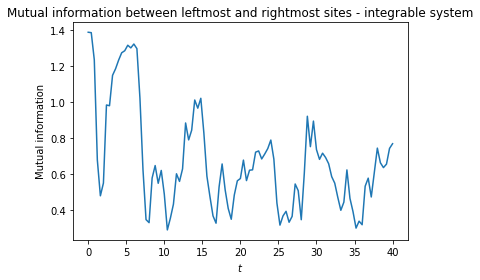

In [19]:
plot_Choi_I(Hi(n_qubits), t0, sys_type = 'integrable system')

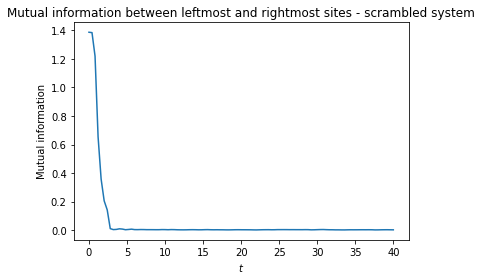

In [20]:
plot_Choi_I(Hs(n_qubits), t0, sys_type = 'scrambled system')

For the scrambled Hamiltonian the mutual information between the leftmost and rightmost states decays to zero. On the other hand, that of the integrable system stays non-zero and oscillates about a non-zero value.

## Changing parameters

Consider now new Hamiltonians. These are defined at the top of the notebook

#### Hamiltonian 3

Consider a Hamiltonian that, like $H_i$, is integrable, but which is away from the Ising critical point.

In [21]:
n_qubits = 6
t0=1000

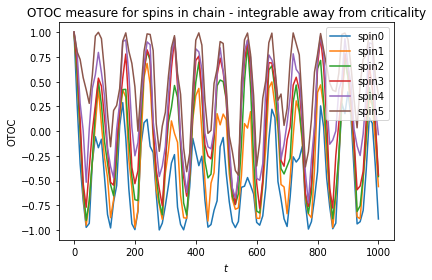

In [22]:
plot_OTOC_vs_t(H3(n_qubits), t0, 'integrable away from criticality', t_steps = 101)

Similar behaviour to integrable system at critical point, but lower frequency of oscillation of OTOC.

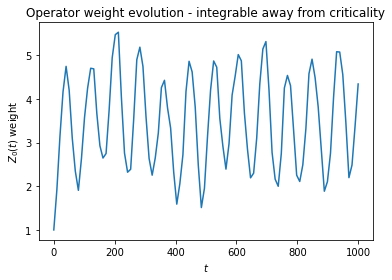

In [23]:
plot_Z0_weight_vs_t(H3(n_qubits), t0, 'integrable away from criticality', t_steps = 100)

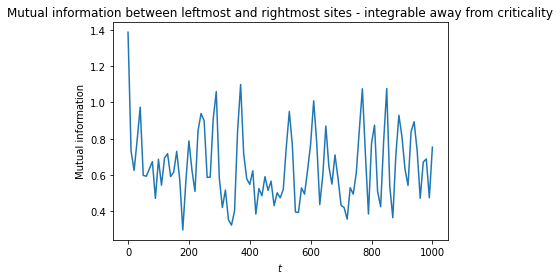

In [24]:
plot_Choi_I(H3(n_qubits), t0, 'integrable away from criticality')

#### Hamiltonian 4

Now try a model with both longitudinal and transverse fields, but with $h = J$.

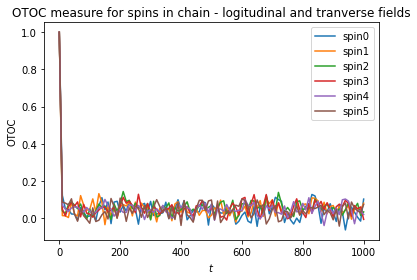

In [25]:
plot_OTOC_vs_t(H4(n_qubits), t0, 'logitudinal and tranverse fields', t_steps = 101)

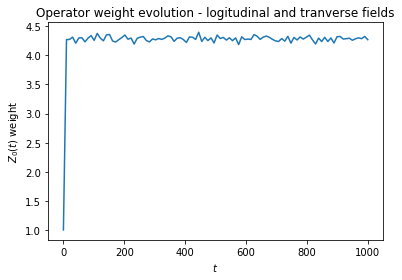

In [26]:
plot_Z0_weight_vs_t(H4(n_qubits), t0, 'logitudinal and tranverse fields', t_steps = 100)

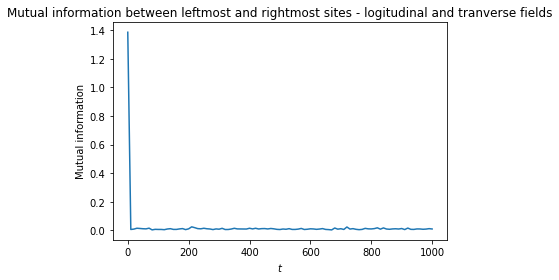

In [27]:
plot_Choi_I(H4(n_qubits), t0, 'logitudinal and tranverse fields')